In [2]:
import pandas as pd

df = pd.read_csv('/Users/JooAnLee/mid_project/src/datasets/수도권_아파트_청약_뉴스_크롤링_청약기간내.csv')
df.head(5)

,공고번호,apartment,title,content,url
0,2025000043,부천 JY 포에시아,'안동용상하늘채리버스카이' 등 1205가구 분양예정[분양캘린더],견본주택 '용현우방아이유쉘센트럴마린' 개관[서울=뉴시스][서울=뉴시스]정진형 기자 ...,https://n.news.naver.com/mnews/article/003/001...
1,2025000043,부천 JY 포에시아,다음 주 전국 분양물량 1205가구에 그쳐…서울은 '無',다음 주 분양 물량이 전주의 절반에도 미치지 못하는 1200여가구에 그칠 것으로 보...,https://n.news.naver.com/mnews/article/277/000...
2,2025000043,부천 JY 포에시아,분양 성수기인데…내주 전국서 1205가구 공급 그쳐,부동산R114 주간 부동산 분양 캘린더봄철 분양 성수기에도 분양 시장은 침체기가 이...,https://n.news.naver.com/mnews/article/015/000...
3,2025000020,e편한세상 제물포역 파크메종(조합원 취소분),"3월 첫째주, 전국 2334가구 청약…지방 물량 집중",전국 6곳 청약 접수서울·인천 수도권 2곳3월 첫째 주 전국 6곳에서 총 2334가...,https://n.news.naver.com/mnews/article/277/000...
4,2025000020,e편한세상 제물포역 파크메종(조합원 취소분),[주간분양] 수도권 청약 물량 희귀…전국 2334가구 중 35가구,전국 6곳 중 4곳이 지방…2299가구 공급28일 리얼투데이에 따르면 3월 첫째 주...,https://n.news.naver.com/mnews/article/119/000...


In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from konlpy.tag import Okt
import re

In [4]:
# 코퍼스 생성 (content 컬럼 데이터를 리스트로 변환)
corpus = df['content'].tolist()
print(corpus[:3])

["견본주택 '용현우방아이유쉘센트럴마린' 개관[서울=뉴시스][서울=뉴시스]정진형 기자 = 부동산R114는 3월 둘째 주 전국 3개 단지 총 1205가구가 분양을 시작한다고 8일 밝혔다. 모두 일반분양 물량이다.청약 접수는 경기 부천시 심곡동 '부천JY포에시아', 경북 안동시 용상동 '안동용상하늘채리버스카이', 울산 울주군 삼남읍 '울산에피트스타시티' 등에서 진행된다. 모델하우스는 인천 미추홀구 용현동 ‘용현우방아이유쉘센트럴마린’ 1곳이 개관한다.코오롱글로벌은 경북 안동시 용상동 일원에 '안동용상하늘채리버스카이'를 분양한다. 지하 2층~지상 최고 26층, 9개동, 전용면적 84㎡, 총 548가구 규모다. 단지 앞 경동로를 통한 안동 시내·외 이동이 편리하며 용상교리신국도를 비롯한 용상중로, 안동 외곽순환도로 교차로 등이 개통되면 교통 여건이 개선될 전망이다. 선어대 생태공원, 낙천공원, 낙동강 등 자연환경이 풍부하며 안동다목적체육관, 안동문화관광단지가 자리해 생활 편의성이 좋다.SM스틸·SM경남기업은 인천 미추홀구 용현동 일원에서 새한아파트 주택재건축을 통해 주상복합 아파트 '용현우방아이유쉘센트럴마린'을 분양할 예정이다. 지하 3층~지상 최고 41층, 2개동, 전용면적 59~76㎡, 총 252가구 중 아파트 196가구(오피스텔 76실 별도)를 일반분양한다. 수인분당선 숭의역을 이용할 수 있고 제2경인고속도로, 수도권제2순환고속도로 등 광역 교통망도 잘 갖춰져 있다. 신선초, 신흥중, 신흥여중 등 학교가 가깝고 인하대병원, 옹진군청, 대형마트 등 기반 시설도 인접한다．", '다음 주 분양 물량이 전주의 절반에도 미치지 못하는 1200여가구에 그칠 것으로 보인다.8일 부동산R114에 따르면 오는 10일부터 16일까지 전국에서 3개 단지, 1205가구가 분양된다. 이는 전주 2753가구와 비교하면 56% 감소한 수치다.서울은 분양 물량이 전무하다. 지난달 래미안 원페를라 공급을 마지막으로 5주째 일반 분양 물량이 없다.공급 예정인 3개 단지는 경기 부천시 심곡동 \'

In [5]:
# 형태소 분석기 설정
okt = Okt()

# 불용어 정리
with open('stopwords-ko.txt', 'r') as f:
  list_file = f.readlines() 
stopwords_default = [word[:-1] for word in list_file ]
stopwords_default
stopwords = stopwords_default # 기본

# 1. 텍스트 정제 함수 (특수문자, 숫자 제거)
def clean_text(text):
    text = re.sub(r'\[.*?\]|\(.*?\)', '', text) # (), [] 괄호 안 내용 제거
    text = re.sub(r'[^가-힣\s]', '', text)  # 한글과 공백 제외 문자 제거
    text = re.sub(r'\s+', ' ', text).strip()  # 연속 공백 제거
    return text

# 2. 형태소 분석을 통한 명사 추출 함수
def extract_nouns(text):
    nouns = okt.nouns(text)  # 형태소만 추출
    nouns = [word for word in nouns if word not in stopwords and len(word) > 1]  # 불용어 제거 및 한 글자 단어 제외
    return ' '.join(nouns)

# 3. 전체 데이터 전처리
corpus = df['content'].tolist()
cleaned_corpus = [extract_nouns(clean_text(text)) for text in corpus]  # 정제 + 명사 추출

In [1]:
pip install bertopic

  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached regex-2024.11.6-cp311-cp311-macosx_11_0_arm64.whl.metadata (40 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 23.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 23.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 23.0 MB/s eta 0:00:00 0:00:01
Using cached regex-2024.11.6-cp311-cp311-macosx_11_0_arm64.whl (284 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 24.9 MB/s eta 0:00:00
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 18.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [19]:
from bertopic import BERTopic
import pandas as pd

# 전처리된 데이터 사용
corpus = cleaned_corpus

# BERTopic 모델 생성
model = BERTopic(verbose=True, language='multilingual', nr_topics=8)  # 토픽 수는 필요에 따라 조정

# 모델 학습 및 토픽 추출
topics, probs = model.fit_transform(corpus)

# 결과 출력
print("토픽 분포:")
print(topics)
print("토픽 확률:")
print(probs)

# 토픽별 키워드 추출 - 수정된 부분
topic_words = {}
topic_info = model.get_topic_info()

# 유효한 토픽만 처리 (-1은 아웃라이어 토픽)
for idx, row in topic_info.iterrows():
    topic_id = row['Topic']
    if topic_id != -1:  # 아웃라이어 토픽 제외
        try:
            words = [word for word, _ in model.get_topic(topic_id)]
            topic_words[topic_id] = words
        except:
            print(f"토픽 {topic_id}에 대한 키워드를 추출할 수 없습니다.")

# 결과 출력
for topic_id, words in topic_words.items():
    print(f"토픽 {topic_id}: {words[:10]}")  # 각 토픽의 상위 10개 키워드만 출력

2025-03-19 15:58:52,314 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 62/62 [00:20<00:00,  3.09it/s]
2025-03-19 15:59:19,153 - BERTopic - Embedding - Completed ✓
2025-03-19 15:59:19,153 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 15:59:22,719 - BERTopic - Dimensionality - Completed ✓
2025-03-19 15:59:22,720 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 15:59:23,418 - BERTopic - Cluster - Completed ✓
2025-03-19 15:59:23,419 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 15:59:23,619 - BERTopic - Representation - Completed ✓
2025-03-19 15:59:23,619 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 15:59:23,789 - BERTopic - Topic reduction - Reduced number of topics from 33 to 8


토픽 분포:
[-1, 1, 1, -1, -1, -1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 0, 0, 2, 6, -1, -1, -1, 1, -1, 0, -1, -1, 2, -1, 1, -1, 2, 1, -1, 1, 0, 1, 0, -1, 1, 1, 0, 0, -1, 0, 2, 5, 1, 2, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 0, 1, 0, 0, 1, -1, 0, -1, 0, 1, 0, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 2, -1, 3, -1, -1, -1, -1, 4, -1, -1, 1, -1, 4, -1, 1, -1, -1, -1, 1, 3, -1, -1, -1, -1, 0, -1, 0, -1, -1, 1, -1, -1, 4, 3, -1, -1, 1, 1, 2, 0, -1, 2, -1, -1, 1, 0, 0, 0, -1, 0, 0, 4, 0, -1, 0, 0, -1, -1, 0, 0, 1, 1, 0, -1, 0, 0, 0, -1, 0, 0, 1, 0, 1, -1, 5, -1, 1, -1, 2, -1, 0, 6, 0, 0, -1, 1, 0, -1, -1, -1, -1, -1, 2, 0, -1, -1, -1, -1, 0, -1, -1, 2, 2, 1, 0, 1, 0, -1, 1, 1, 5, 5, 0, 0, 2, 0, 6, 2, 0, -1, 1, 1, -1, 2, 0, 1, 1, 1, -1, -1, 4, -1, 3, -1, -1, -1, -1, -1, 0, 0, 0, -1, -1, 0, 0, -1, -1, 0, 0, 0, 0, 0, -1, -1, -1, 0, 1, -1, -1, -1, 1, -1, -1, -1, 2, -1, -1, -1, 1, 0, -1, -1, 1, -1, 0, 1, 0, 0, 0, 0, 0, 1, -1, -1, 0, 0, 1, 1, -1, 2, 2, -1, -1, -1, 3, 2,

In [28]:
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora

# 토큰화된 문서 준비 (BERTopic 모델에서 사용한 전처리 방식과 동일하게 적용)
# 만약 이미 토큰화된 문서가 있다면 그것을 사용
tokenized_docs = [doc.split() for doc in cleaned_corpus]  # 간단한 예시, 실제로는 더 복잡한 토큰화 필요할 수 있음

# 사전 생성
dictionary = corpora.Dictionary(tokenized_docs)

# 코퍼스 생성
corpus_bow = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# 토픽별 키워드 리스트 준비 (아웃라이어 토픽 제외)
topics_words_list = []
for topic_id, words in topic_words.items():
    if topic_id != -1:  # 아웃라이어 토픽 제외
        topics_words_list.append(words)

# Coherence 모델 생성 및 점수 계산 (NPMI 방식 사용)
coherence_model = CoherenceModel(
    topics=topics_words_list,
    texts=tokenized_docs,
    dictionary=dictionary,
    coherence='c_npmi'  # NPMI 방식 사용
)

# Coherence 점수 계산
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score (NPMI): {coherence_score}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Coherence Score (NPMI): 0.06859118869642067


2025-03-19 16:55:11,103 - BERTopic - Embedding - Transforming documents to embeddings.


토픽 수 7에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:20<00:00,  2.99it/s]
2025-03-19 16:55:50,051 - BERTopic - Embedding - Completed ✓
2025-03-19 16:55:50,054 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 16:55:53,958 - BERTopic - Dimensionality - Completed ✓
2025-03-19 16:55:53,959 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 16:55:54,053 - BERTopic - Cluster - Completed ✓
2025-03-19 16:55:54,054 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 16:55:54,485 - BERTopic - Representation - Completed ✓
2025-03-19 16:55:54,486 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 16:55:54,487 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` 

토픽 수 7의 coherence score: 0.08089834636458089
토픽 수 8에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:20<00:00,  3.04it/s]
2025-03-19 16:56:27,782 - BERTopic - Embedding - Completed ✓
2025-03-19 16:56:27,784 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 16:56:31,537 - BERTopic - Dimensionality - Completed ✓
2025-03-19 16:56:31,540 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 16:56:31,606 - BERTopic - Cluster - Completed ✓
2025-03-19 16:56:31,607 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 16:56:34,690 - BERTopic - Representation - Completed ✓
2025-03-19 16:56:34,699 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 16:56:34,879 - BERTopic - Topic reduction - Reduced number of topics from 26 to 8
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers`

토픽 수 8의 coherence score: 0.04248543959073546
토픽 수 9에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:22<00:00,  2.71it/s]
2025-03-19 16:57:10,465 - BERTopic - Embedding - Completed ✓
2025-03-19 16:57:10,469 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 16:57:14,389 - BERTopic - Dimensionality - Completed ✓
2025-03-19 16:57:14,394 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 16:57:14,492 - BERTopic - Cluster - Completed ✓
2025-03-19 16:57:14,493 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 16:57:14,835 - BERTopic - Representation - Completed ✓
2025-03-19 16:57:14,836 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 16:57:14,837 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` 

토픽 수 9의 coherence score: 0.08089834636458089
토픽 수 10에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:26<00:00,  2.36it/s]
2025-03-19 16:58:00,618 - BERTopic - Embedding - Completed ✓
2025-03-19 16:58:00,622 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 16:58:04,379 - BERTopic - Dimensionality - Completed ✓
2025-03-19 16:58:04,382 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 16:58:04,456 - BERTopic - Cluster - Completed ✓
2025-03-19 16:58:04,457 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 16:58:04,748 - BERTopic - Representation - Completed ✓
2025-03-19 16:58:04,749 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 16:58:04,750 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` 

토픽 수 10의 coherence score: 0.08089834636458089
토픽 수 11에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:27<00:00,  2.28it/s]
2025-03-19 16:58:53,555 - BERTopic - Embedding - Completed ✓
2025-03-19 16:58:53,561 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 16:58:57,376 - BERTopic - Dimensionality - Completed ✓
2025-03-19 16:58:57,380 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 16:58:57,473 - BERTopic - Cluster - Completed ✓
2025-03-19 16:58:57,474 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 16:58:57,767 - BERTopic - Representation - Completed ✓
2025-03-19 16:58:57,768 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 16:58:57,959 - BERTopic - Topic reduction - Reduced number of topics from 33 to 11
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers

토픽 수 11의 coherence score: 0.07307391414814429
토픽 수 12에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:17<00:00,  3.53it/s]
2025-03-19 16:59:29,286 - BERTopic - Embedding - Completed ✓
2025-03-19 16:59:29,287 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 16:59:32,822 - BERTopic - Dimensionality - Completed ✓
2025-03-19 16:59:32,823 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 16:59:32,889 - BERTopic - Cluster - Completed ✓
2025-03-19 16:59:32,890 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 16:59:33,173 - BERTopic - Representation - Completed ✓
2025-03-19 16:59:33,173 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 16:59:33,353 - BERTopic - Topic reduction - Reduced number of topics from 28 to 12
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers

토픽 수 12의 coherence score: 0.05795387790799133
토픽 수 13에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:18<00:00,  3.28it/s]
2025-03-19 17:00:04,272 - BERTopic - Embedding - Completed ✓
2025-03-19 17:00:04,274 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:00:07,906 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:00:07,909 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:00:08,037 - BERTopic - Cluster - Completed ✓
2025-03-19 17:00:08,042 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:00:08,277 - BERTopic - Representation - Completed ✓
2025-03-19 17:00:08,278 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:00:08,458 - BERTopic - Topic reduction - Reduced number of topics from 32 to 13
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers

토픽 수 13의 coherence score: 0.0918991816682319
토픽 수 14에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:17<00:00,  3.45it/s]
2025-03-19 17:00:38,563 - BERTopic - Embedding - Completed ✓
2025-03-19 17:00:38,564 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:00:42,882 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:00:42,885 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:00:42,996 - BERTopic - Cluster - Completed ✓
2025-03-19 17:00:42,998 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:00:43,286 - BERTopic - Representation - Completed ✓
2025-03-19 17:00:43,286 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:00:43,466 - BERTopic - Topic reduction - Reduced number of topics from 27 to 14
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers

토픽 수 14의 coherence score: 0.069081790325472
토픽 수 15에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:21<00:00,  2.94it/s]
2025-03-19 17:01:16,949 - BERTopic - Embedding - Completed ✓
2025-03-19 17:01:16,951 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:01:20,671 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:01:20,674 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:01:20,745 - BERTopic - Cluster - Completed ✓
2025-03-19 17:01:20,745 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:01:21,082 - BERTopic - Representation - Completed ✓
2025-03-19 17:01:21,082 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:01:21,083 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` 

토픽 수 15의 coherence score: 0.08089834636458089
토픽 수 16에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:19<00:00,  3.20it/s]
2025-03-19 17:01:52,339 - BERTopic - Embedding - Completed ✓
2025-03-19 17:01:52,339 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:01:55,990 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:01:55,991 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:01:56,059 - BERTopic - Cluster - Completed ✓
2025-03-19 17:01:56,060 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:01:56,403 - BERTopic - Representation - Completed ✓
2025-03-19 17:01:56,403 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:01:56,585 - BERTopic - Topic reduction - Reduced number of topics from 31 to 16
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers

토픽 수 16의 coherence score: 0.06591646175918663
토픽 수 17에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:19<00:00,  3.25it/s]
2025-03-19 17:02:31,581 - BERTopic - Embedding - Completed ✓
2025-03-19 17:02:31,582 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:02:35,094 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:02:35,095 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:02:35,161 - BERTopic - Cluster - Completed ✓
2025-03-19 17:02:35,162 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:02:35,354 - BERTopic - Representation - Completed ✓
2025-03-19 17:02:35,354 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:02:35,355 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` 

토픽 수 17의 coherence score: 0.08089834636458089
토픽 수 18에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:18<00:00,  3.30it/s]
2025-03-19 17:03:05,686 - BERTopic - Embedding - Completed ✓
2025-03-19 17:03:05,687 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:03:09,188 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:03:09,190 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:03:09,256 - BERTopic - Cluster - Completed ✓
2025-03-19 17:03:09,257 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:03:09,470 - BERTopic - Representation - Completed ✓
2025-03-19 17:03:09,470 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:03:09,717 - BERTopic - Topic reduction - Reduced number of topics from 34 to 18
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers

토픽 수 18의 coherence score: 0.07895117295349677
토픽 수 19에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:20<00:00,  2.97it/s]
2025-03-19 17:03:41,502 - BERTopic - Embedding - Completed ✓
2025-03-19 17:03:41,502 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:03:45,109 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:03:45,111 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:03:45,183 - BERTopic - Cluster - Completed ✓
2025-03-19 17:03:45,183 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:03:45,404 - BERTopic - Representation - Completed ✓
2025-03-19 17:03:45,405 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:03:45,406 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` 

토픽 수 19의 coherence score: 0.08089834636458089
토픽 수 20에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:18<00:00,  3.27it/s]
2025-03-19 17:04:15,351 - BERTopic - Embedding - Completed ✓
2025-03-19 17:04:15,351 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:04:18,894 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:04:18,897 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:04:18,959 - BERTopic - Cluster - Completed ✓
2025-03-19 17:04:18,959 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:04:19,145 - BERTopic - Representation - Completed ✓
2025-03-19 17:04:19,146 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:04:19,147 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` 

토픽 수 20의 coherence score: 0.08089834636458089
토픽 수 21에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:23<00:00,  2.68it/s]
2025-03-19 17:04:52,617 - BERTopic - Embedding - Completed ✓
2025-03-19 17:04:52,620 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:04:56,351 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:04:56,355 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:04:56,451 - BERTopic - Cluster - Completed ✓
2025-03-19 17:04:56,452 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:04:56,743 - BERTopic - Representation - Completed ✓
2025-03-19 17:04:56,744 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:04:56,938 - BERTopic - Topic reduction - Reduced number of topics from 26 to 21
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers

토픽 수 21의 coherence score: 0.06236353000249288
토픽 수 22에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:19<00:00,  3.16it/s]
2025-03-19 17:05:31,904 - BERTopic - Embedding - Completed ✓
2025-03-19 17:05:31,905 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:05:35,437 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:05:35,438 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:05:35,504 - BERTopic - Cluster - Completed ✓
2025-03-19 17:05:35,504 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:05:35,703 - BERTopic - Representation - Completed ✓
2025-03-19 17:05:35,704 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:05:35,705 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` 

토픽 수 22의 coherence score: 0.08089834636458089
토픽 수 23에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:17<00:00,  3.51it/s]
2025-03-19 17:06:05,598 - BERTopic - Embedding - Completed ✓
2025-03-19 17:06:05,598 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:06:09,137 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:06:09,138 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:06:09,946 - BERTopic - Cluster - Completed ✓
2025-03-19 17:06:09,947 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:06:10,152 - BERTopic - Representation - Completed ✓
2025-03-19 17:06:10,152 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:06:10,336 - BERTopic - Topic reduction - Reduced number of topics from 29 to 23
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers

토픽 수 23의 coherence score: 0.07150357339345073
토픽 수 24에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:18<00:00,  3.41it/s]
2025-03-19 17:06:40,640 - BERTopic - Embedding - Completed ✓
2025-03-19 17:06:40,641 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:06:44,331 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:06:44,334 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:06:44,404 - BERTopic - Cluster - Completed ✓
2025-03-19 17:06:44,405 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:06:44,619 - BERTopic - Representation - Completed ✓
2025-03-19 17:06:44,619 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:06:44,802 - BERTopic - Topic reduction - Reduced number of topics from 31 to 24
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers

토픽 수 24의 coherence score: 0.06912857879765015
토픽 수 25에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:17<00:00,  3.57it/s]
2025-03-19 17:07:14,029 - BERTopic - Embedding - Completed ✓
2025-03-19 17:07:14,030 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:07:17,563 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:07:17,563 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:07:17,627 - BERTopic - Cluster - Completed ✓
2025-03-19 17:07:17,628 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:07:17,820 - BERTopic - Representation - Completed ✓
2025-03-19 17:07:17,821 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:07:17,822 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` 

토픽 수 25의 coherence score: 0.08089834636458089
토픽 수 26에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:17<00:00,  3.55it/s]
2025-03-19 17:07:46,662 - BERTopic - Embedding - Completed ✓
2025-03-19 17:07:46,662 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:07:50,186 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:07:50,187 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:07:50,999 - BERTopic - Cluster - Completed ✓
2025-03-19 17:07:51,000 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:07:51,454 - BERTopic - Representation - Completed ✓
2025-03-19 17:07:51,455 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:07:51,456 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` 

토픽 수 26의 coherence score: 0.08089834636458089
토픽 수 27에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:18<00:00,  3.36it/s]
2025-03-19 17:08:20,560 - BERTopic - Embedding - Completed ✓
2025-03-19 17:08:20,561 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:08:24,148 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:08:24,150 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:08:24,222 - BERTopic - Cluster - Completed ✓
2025-03-19 17:08:24,223 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:08:24,481 - BERTopic - Representation - Completed ✓
2025-03-19 17:08:24,482 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:08:24,667 - BERTopic - Topic reduction - Reduced number of topics from 31 to 27
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers

토픽 수 27의 coherence score: 0.04344142846206611
토픽 수 28에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:17<00:00,  3.53it/s]
2025-03-19 17:08:56,019 - BERTopic - Embedding - Completed ✓
2025-03-19 17:08:56,020 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:08:59,541 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:08:59,542 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:08:59,605 - BERTopic - Cluster - Completed ✓
2025-03-19 17:08:59,605 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:08:59,802 - BERTopic - Representation - Completed ✓
2025-03-19 17:08:59,802 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:08:59,803 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` 

토픽 수 28의 coherence score: 0.08089834636458089
토픽 수 29에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:17<00:00,  3.57it/s]
2025-03-19 17:09:28,527 - BERTopic - Embedding - Completed ✓
2025-03-19 17:09:28,528 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:09:32,044 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:09:32,045 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:09:32,108 - BERTopic - Cluster - Completed ✓
2025-03-19 17:09:32,109 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:09:32,320 - BERTopic - Representation - Completed ✓
2025-03-19 17:09:32,321 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:09:32,322 - BERTopic - Topic reduction - Reduced number of topics from 29 to 29
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers

토픽 수 29의 coherence score: 0.05068826851697423
토픽 수 30에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:17<00:00,  3.55it/s]
2025-03-19 17:10:01,785 - BERTopic - Embedding - Completed ✓
2025-03-19 17:10:01,786 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:10:05,304 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:10:05,305 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:10:05,369 - BERTopic - Cluster - Completed ✓
2025-03-19 17:10:05,370 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:10:05,574 - BERTopic - Representation - Completed ✓
2025-03-19 17:10:05,575 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:10:05,576 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` 

토픽 수 30의 coherence score: 0.08089834636458089
토픽 수 31에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:17<00:00,  3.59it/s]
2025-03-19 17:10:34,781 - BERTopic - Embedding - Completed ✓
2025-03-19 17:10:34,782 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:10:38,285 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:10:38,286 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:10:38,352 - BERTopic - Cluster - Completed ✓
2025-03-19 17:10:38,353 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:10:38,548 - BERTopic - Representation - Completed ✓
2025-03-19 17:10:38,550 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:10:38,552 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` 

토픽 수 31의 coherence score: 0.08089834636458089
토픽 수 32에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:17<00:00,  3.60it/s]
2025-03-19 17:11:07,515 - BERTopic - Embedding - Completed ✓
2025-03-19 17:11:07,516 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:11:10,965 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:11:10,965 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:11:11,031 - BERTopic - Cluster - Completed ✓
2025-03-19 17:11:11,031 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:11:11,242 - BERTopic - Representation - Completed ✓
2025-03-19 17:11:11,242 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:11:11,243 - BERTopic - Topic reduction - Reduced number of topics from 30 to 30
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers

토픽 수 32의 coherence score: 0.054315118964997605
토픽 수 33에 대한 coherence score 계산 중...


Batches: 100%|██████████| 62/62 [00:18<00:00,  3.37it/s]
2025-03-19 17:11:42,881 - BERTopic - Embedding - Completed ✓
2025-03-19 17:11:42,882 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-19 17:11:46,506 - BERTopic - Dimensionality - Completed ✓
2025-03-19 17:11:46,508 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-19 17:11:46,579 - BERTopic - Cluster - Completed ✓
2025-03-19 17:11:46,580 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-19 17:11:46,797 - BERTopic - Representation - Completed ✓
2025-03-19 17:11:46,798 - BERTopic - Topic reduction - Reducing number of topics
2025-03-19 17:11:46,798 - BERTopic - Topic reduction - Reduced number of topics from 30 to 30
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers

토픽 수 33의 coherence score: 0.03205439434582773

최적의 토픽 수: 13, Coherence Score: 0.0918991816682319


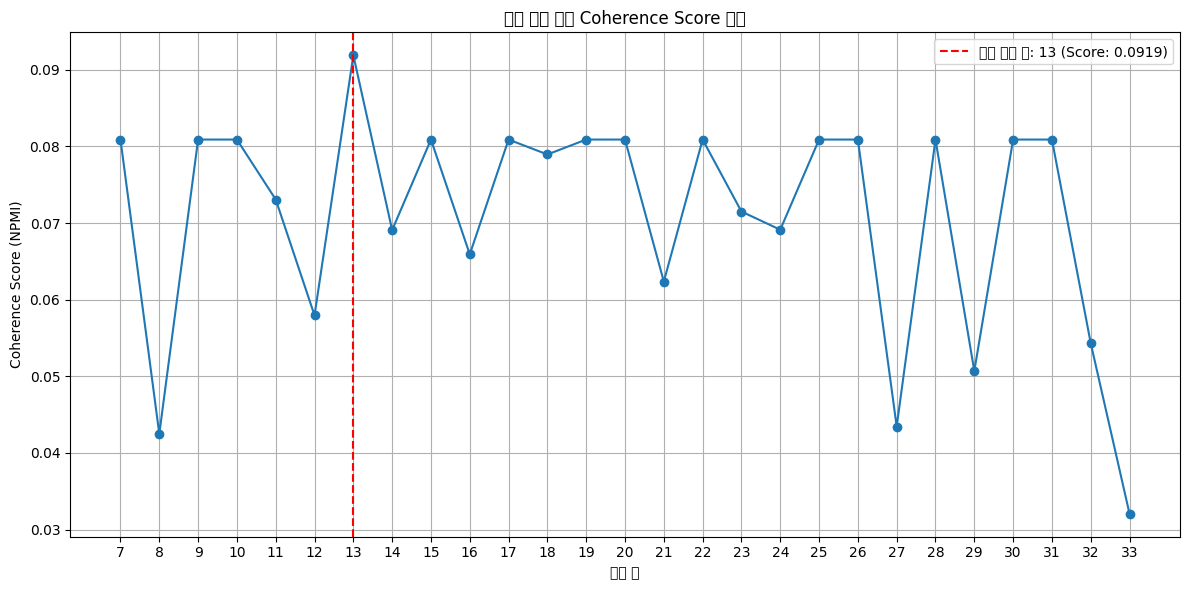

In [29]:
from bertopic import BERTopic
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
import numpy as np
import matplotlib.pyplot as plt

# 토큰화된 문서 준비
tokenized_docs = [doc.split() for doc in cleaned_corpus]

# 사전 생성
dictionary = corpora.Dictionary(tokenized_docs)

# 코퍼스 생성
corpus_bow = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# 다양한 토픽 수에 대한 coherence score 계산
coherence_scores = {}
for nr_topics in range(7, 34):
    print(f"토픽 수 {nr_topics}에 대한 coherence score 계산 중...")
    
    # BERTopic 모델 생성 및 학습
    model = BERTopic(verbose=True, language='multilingual', nr_topics=nr_topics)
    topics, _ = model.fit_transform(cleaned_corpus)
    
    # 토픽별 키워드 추출
    topic_words = {}
    topic_info = model.get_topic_info()
    
    for idx, row in topic_info.iterrows():
        topic_id = row['Topic']
        if topic_id != -1:  # 아웃라이어 토픽 제외
            try:
                words = [word for word, _ in model.get_topic(topic_id)]
                topic_words[topic_id] = words
            except:
                print(f"토픽 {topic_id}에 대한 키워드를 추출할 수 없습니다.")
    
    # 토픽별 키워드 리스트 준비
    topics_words_list = [words for topic_id, words in topic_words.items() if topic_id != -1]
    
    # Coherence 모델 생성 및 점수 계산
    coherence_model = CoherenceModel(
        topics=topics_words_list,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence='c_npmi'
    )
    
    coherence_scores[nr_topics] = coherence_model.get_coherence()
    print(f"토픽 수 {nr_topics}의 coherence score: {coherence_scores[nr_topics]}")

# 최적의 토픽 수 찾기
best_nr_topics = max(coherence_scores, key=coherence_scores.get)
best_coherence = coherence_scores[best_nr_topics]
print(f"\n최적의 토픽 수: {best_nr_topics}, Coherence Score: {best_coherence}")

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(list(coherence_scores.keys()), list(coherence_scores.values()), marker='o')
plt.axvline(x=best_nr_topics, color='r', linestyle='--', 
           label=f'최적 토픽 수: {best_nr_topics} (Score: {best_coherence:.4f})')
plt.xlabel('토픽 수')
plt.ylabel('Coherence Score (NPMI)')
plt.title('토픽 수에 따른 Coherence Score 변화')
plt.xticks(list(coherence_scores.keys()))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# 최적의 토픽 수 찾기
best_nr_topics = max(coherence_scores, key=coherence_scores.get)
best_coherence = coherence_scores[best_nr_topics]

# 최적의 토픽 수 및 Coherence Score 출력
print(f"\n최적의 토픽 수: {best_nr_topics}, Coherence Score: {best_coherence:.4f}")


최적의 토픽 수: 13, Coherence Score: 0.0919
